<a href="https://colab.research.google.com/github/LamQuynhf/CS114.K21.KHTN/blob/master/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Case Study: Sarcasm Headline Detection
- Nguyễn Khánh Toàn - 18521509
- Nguyễn Lâm Quỳnh - 18521326

# Crawl Data

##Sarcasm Title from https://www.theonion.com/

Using 

1.   Requests to get data from Website
2.   BeatifulSoup to get PostIndex from data
3.   Newspaper.Article to get Title



In [ ]:
!pip install newspaper3k

In [ ]:
import requests
from bs4 import BeautifulSoup 
from newspaper import Article
post_ids = set()
def get_html(url):  
  """get the content of the url"""  
  response = requests.get(url)
  response.encoding = 'utf-8'  
  return response.text  


def get_pmid(html):
    all_ids = set()
    soup = BeautifulSoup(html, 'lxml') 
    for id_tag in soup.find_all('article'):
        start = str(id_tag).find("data-id=")
        if len(post_ids) < 1000:
            post_ids.add(str(id_tag)[start+9:start+19])
index = 1
while len(post_ids)<1000:
    url_ncbi = "https://www.theonion.com/tag/news-in-brief?startIndex={}".format(index)  
    html = get_html(url_ncbi)
    get_pmid(html)
    index+=20

In [ ]:
from newspaper import Article
fi = open('/content/drive/My Drive/Datasets/1-sarcasm.txt','w')

for id in post_ids:
    url = 'https://www.theonion.com/'+id
    article = Article(url)
    article.download()
    article.parse()
    fi.write(article.title+'\n')
fi.close()


##Non-Sarcasm Title: Using Scraper Extension


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
nonsarcasm_title = []
sarcasm_title = []
f0 = open('/content/drive/My Drive/Datasets/0-sarcasm.txt','r')
f1 = open('/content/drive/My Drive/Datasets/1-sarcasm.txt','r')
for line in f0:
    nonsarcasm_title.append(line)
for line in f1:
    sarcasm_title.append(line)
f0.close()
f1.close()

## 

In [ ]:
import pandas as pd
d = {'headline': nonsarcasm_title + sarcasm_title, 'is_sarcastic': [0]*1000+[1]*1000}
data_test = pd.DataFrame(data=d)

#Train and Test

In [ ]:
import numpy as np
import re, time
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data_train = pd.read_json('/content/drive/My Drive/Datasets/30764_533474_compressed_Sarcasm_Headlines_Dataset.json.zip', lines=True)

##Cleaning the data:

Although, it looks that our data is clean but the headline column has some special symbols that have to be eliminated.

So, we are using Regular Expression to eliminate special symbols.

In [ ]:
# Relacing special symbols and digits in headline column
# re stands for Regular Expression
data_train['headline'] = data_train['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))
data_test['headline']  =  data_test['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

##Feature and label extraction:

It’s time to extract features and labels out of our data. It seems that we may consider article_link and headline as features. But, article_link doesn’t play an important role in predicting the label. 

So, the only feature that we have is the headline column. And is_sarcastic is the only label.

In [ ]:
# getting features and labels
features_train = data_train['headline']
labels_train = data_train['is_sarcastic']

features_test = data_test['headline']
labels_test = data_test['is_sarcastic']

##Stemming of features:

Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

for example:-

original word: “reading” and “reader”.

after stemming: read (for all the above two words).

In [ ]:
# Đưa các từ về nghĩa gốc
ps = PorterStemmer()
features_train = features_train.apply(lambda x: x.split())
features_train = features_train.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

features_test = features_test.apply(lambda x: x.split())
features_test = features_test.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

## Vector hoá các Features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#
vectorizer1 = CountVectorizer(analyzer='word',ngram_range=(1,1), max_features=10000) 
features_train = vectorizer1.fit_transform(features_train) 

vectorizer2 = CountVectorizer(vocabulary=vectorizer1.vocabulary_,ngram_range=(1,1)) 
features_test = vectorizer2.fit_transform(features_test) 

##Training and Testing data:-

##Training and testing of models:
Sử dụng các thuật toán ML


###Model 1: linear support vector classifier




In [ ]:
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)

lsvc_train = lsvc.score(features_train, labels_train)
lsvc_test = lsvc.score(features_test, labels_test)

print(lsvc_train)
print(lsvc_test)

0.9601258002920364
0.8695


###Model 2: Gaussuan Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(features_train.toarray(), labels_train)

gnb_train = gnb.score(features_train.toarray(), labels_train)  
gnb_test = gnb.score(features_test.toarray(), labels_test)

print(gnb_train)
print(gnb_test)

0.8390430192070089
0.7745


###Model 3: Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(features_train, labels_train)

lr_train = lr.score(features_train, labels_train)
lr_test = lr.score(features_test, labels_test)

print(lr_train)
print(lr_test)

0.9239956568946797
0.8645


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


###Model 4: Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)

rfc_train = rfc.score(features_train, labels_train)
rfc_test = rfc.score(features_test, labels_test)   

print(rfc_train)
print(rfc_test)

0.9887303905050732
0.914


In [ ]:
def test(title):
    title =title.split()
    title = ' '.join([ps.stem(word) for word in title])
    
    print("LSVC: ", lsvc.predict(vectorizer2.transform([title])))
    print("GNB: ", gnb.predict(vectorizer2.transform([title]).toarray()))
    print("LR: ", lr.predict(vectorizer2.transform([title])))
    print("RFC: ", rfc.predict(vectorizer2.transform([title])))

title = input()
test(title)

Roommate Skulking Around Edge Of Party Like Victorian Ghost Child
LSVC:  [1]
GNB:  [1]
LR:  [1]
RFC:  [1]


# So sánh các model


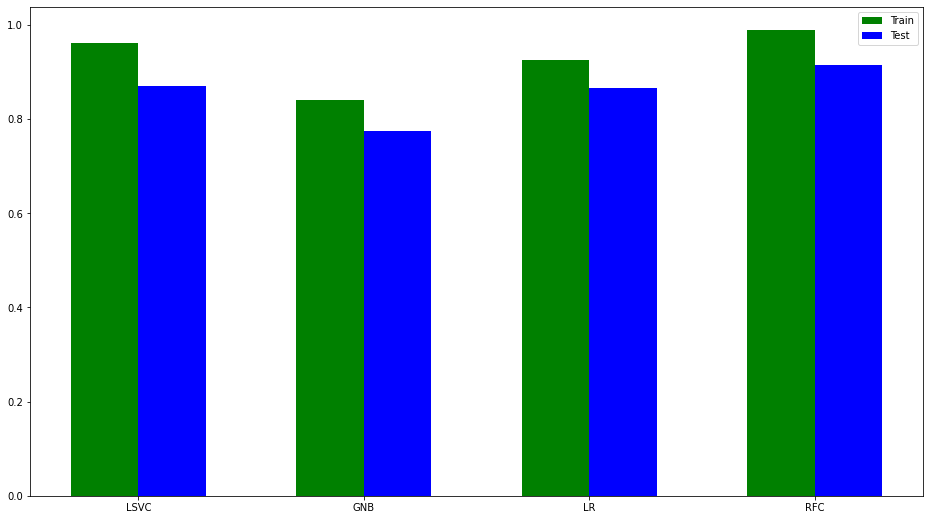

In [ ]:
import matplotlib.pyplot as plt
models_name = ['LSVC', 'GNB', 'LR', 'RFC']
acc_train = [lsvc_train, gnb_train, lr_train, rfc_train]
acc_test = [lsvc_test, gnb_test, lr_test, rfc_test]

index = np.arange(4)
width = 0.3
plt.figure(figsize=(16,9))
plt.bar(index, acc_train, width, color = 'g', label = 'Train')
plt.bar(index+width, acc_test, width, color = 'b', label = 'Test')

plt.ylabel = 'accuracy'
plt.xlabel = 'algorithm'
plt.xticks(index+width/2, models_name)

plt.legend(loc='best')
plt.show()

# Đánh Giá
Các Models cho kết quả tương đối cao
*   Random Forest Classifier cho kế quả tối nhất (Train: 0.988, Test: 0.914)
*   Gaussuan Naive Bayes cho kế quả thấp nhất (Train: 0.839, Test: 0.7745)



